<a href="https://colab.research.google.com/github/CamCha0928/plane-classification/blob/main/plane-classification/notebooks/Copy_of_train_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des données 

In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar xzf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  20.8M      0  0:02:06  0:02:06 --:--:-- 21.0M


### Packages

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import yaml
import seaborn as sns
import datetime

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image

## Constantes

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
with open(r'parametre.yaml') as yaml_data:
  params = yaml.safe_load(yaml_data)
  print(params)

{'DATA_DIR': 'dataset/data', 'MODELS_DIR': 'model', 'IMAGE_WIDTH': 128, 'IMAGE_HEIGHT': 128, 'IMAGE_DEPTH': 3}


In [10]:
DATA_DIR = pathlib.Path(params['DATA_DIR'])
IMAGE_WIDTH = params['IMAGE_WIDTH']
IMAGE_HEIGHT = params['IMAGE_HEIGHT']
IMAGE_DEPTH = params['IMAGE_DEPTH']
MODELS_DIR = params['MODELS_DIR']

# Lecture des fichiers

Construction DataFrame et redimension des images

In [ ]:
def build_image_database(path, target):
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path): path pattern to read csv file containing images information.
  target (str): name of the target column.

  Returns
  -------
  A pandas dataframe, including target class and path to image.
  """
  _df = pd.read_csv(path, sep='\t',
              names=['all'],
              dtype={'all': str},              # ids are not int but string
            )

  # La fonction split() découpe une chaîne de caractères
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

  # La fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))

  return _df.drop(columns=['all'])

In [ ]:
manufacturer_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer')

In [ ]:
# La fonction :
# - prend un df (argument)
# - prend une ligne (row : argument, l'indice de la ligne)
# - prend une colonne (target : argument)
# - elle affiche la classe (la valeur de target) et l'image associée, pour la ligne en argument

def show_image(df, row, target):
  """Show an image from an image database, with the associated class.

  Parameters
  ----------
  df (pd.DataFrame): images definition dataframe
  row (int): row index in df of image to be displayed
  target (str): name of the target column

  Returns
  -------
  None
  """
  assert target in df.columns, "Missing target column in dataframe"
  assert 'path' in df.columns, "Missing image path in dataframe"
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))
  return

In [ ]:
def load_resize_image(path, height, width):
  """Load an image and resize it to the target size.

  Parameters
  ----------
  path (Path): access path to image file
  height (int): resize image to this height
  width (int): resize image to this width
  
  Returns
  -------
  np.array containing resized image
  """
  return np.array(Image.open(path).resize((width, height)))

In [ ]:
manufacturer_df['resized_image'] = manufacturer_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

Information de classes

In [ ]:
# Suppression des valeurs manquantes et nombre d'avion par catégorie
manufacturer_df['manufacturer'].value_counts(dropna=False)

Boeing                      733
Airbus                      434
Embraer                     233
McDonnell Douglas           232
de Havilland                167
Canadair                    134
Douglas Aircraft Company    133
Cessna                      133
British Aerospace           133
Fokker                      100
Lockheed Corporation         68
Beechcraft                   67
Saab                         67
Gulfstream Aerospace         67
Dassault Aviation            67
Tupolev                      66
ATR                          66
Panavia                      34
Yakovlev                     34
Lockheed Martin              34
Dornier                      34
Antonov                      34
Bombardier Aerospace         33
Ilyushin                     33
Fairchild                    33
Piper                        33
Cirrus Aircraft              33
Supermarine                  33
Robin                        33
Eurofighter                  33
Name: manufacturer, dtype: int64

# Réseau de neurone pour la classification

In [ ]:
def build_classification_model(df: pd.DataFrame, target: str, images: str):
  """Build a TF model using information from target and images columns in dataframe.

  Parameters
  ----------
  df (pd.DataFrame): dataframe with target and images columns
  target (str): column name for target variable
  images (str): column name for images

  Returns
  -------
  TF model built & compiled
  """
  nb_classes = df[target].nunique() # Compute number of classes for output layer
  size = df[images].iloc[0].shape # Compute images size for input layer

  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=size))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(nb_classes, activation='softmax')) # output layer with nb_classes

  #Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model


# Constitution de la base d'apprentissage

Train et Test

In [ ]:
def build_x_and_y(df: pd.DataFrame, target: str, images: str):
  """Build x tensor and y tensor for model fitting.

  Parameters
  ----------
  df (pd.DataFrame): dataframe containing images and target
  target (str): name of target column
  images (str): name of images column

  Returns
  -------
  x (np.array): tensor of x values
  y (np.array): tensor of y values
  """
  x = np.array(df[images].to_list())
  y = tf.keras.utils.to_categorical(df[target].astype('category').cat.codes)
  return x, y


In [ ]:
# Load train & test dataset
train_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt', 'manufacturer')
test_df = build_image_database(DATA_DIR / 'images_manufacturer_test.txt', 'manufacturer')

# Load & resize images
train_df['resized_image'] = train_df.apply(lambda r: load_resize_image(r['path'],
                                                                       IMAGE_HEIGHT, IMAGE_WIDTH),
                                           axis=1)
test_df['resized_image'] = test_df.apply(lambda r: load_resize_image(r['path'],
                                                                       IMAGE_HEIGHT, IMAGE_WIDTH),
                                         axis=1)

# Build tensors for training & testing
X_train, y_train = build_x_and_y(train_df, 'manufacturer', 'resized_image')
X_test, y_test = build_x_and_y(test_df, 'manufacturer', 'resized_image')

# Build TF classification model
model = build_classification_model(train_df, 'manufacturer', 'resized_image')


# Entrainement du modèle 

Classification d'image

In [ ]:
def classify_images(images, model, classes_names=None):
  """Classify images through a TF model.

  Parameters
  ----------
  images (np.array): set of images to classify
  model (tf.keras.Model): TF/Keras model
  classes_names: dictionary with names of classes

  Returns
  -------
  predicted classes
  """

  results = model.predict(images) # predict for images
  classes = np.argmax(results, axis=1) # argmax returns the index of the max value per row
  if classes_names is not None:
    classes = np.array(classes_names[classes])
  return classes

CPU --> TPU

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.21.76.202:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.21.76.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.21.76.202:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
with tpu_strategy.scope():
  model = build_classification_model(train_df, 'manufacturer', 'resized_image')

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 124, 124, 32)      2432      
                                                                 
 conv2d_17 (Conv2D)          (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 60, 60, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 58, 58, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 56, 56, 64)        36928     
                                                      

In [ ]:
%%time
epochs = 30
history = model.fit(X_train, y_train, batch_size=96, epochs=epochs, 
                    validation_data=(X_test, y_test),
                    )

Epoch 1/30
35/35 [==============================] - 38s 799ms/step - loss: 25.3235 - accuracy: 0.1707 - val_loss: 2.9808 - val_accuracy: 0.2214
Epoch 2/30
35/35 [==============================] - 3s 85ms/step - loss: 2.9479 - accuracy: 0.2232 - val_loss: 2.7798 - val_accuracy: 0.2313
Epoch 3/30
35/35 [==============================] - 3s 82ms/step - loss: 2.7705 - accuracy: 0.2256 - val_loss: 2.7102 - val_accuracy: 0.2331
Epoch 4/30
35/35 [==============================] - 3s 84ms/step - loss: 2.6615 - accuracy: 0.2445 - val_loss: 2.6047 - val_accuracy: 0.2466
Epoch 5/30
35/35 [==============================] - 3s 83ms/step - loss: 2.5135 - accuracy: 0.2762 - val_loss: 2.5421 - val_accuracy: 0.2577
Epoch 6/30
35/35 [==============================] - 3s 84ms/step - loss: 2.3378 - accuracy: 0.3119 - val_loss: 2.4907 - val_accuracy: 0.2760
Epoch 7/30
35/35 [==============================] - 3s 83ms/step - loss: 2.1893 - accuracy: 0.3470 - val_loss: 2.4410 - val_accuracy: 0.2868
Epoch 8/30

# Performance du modèle

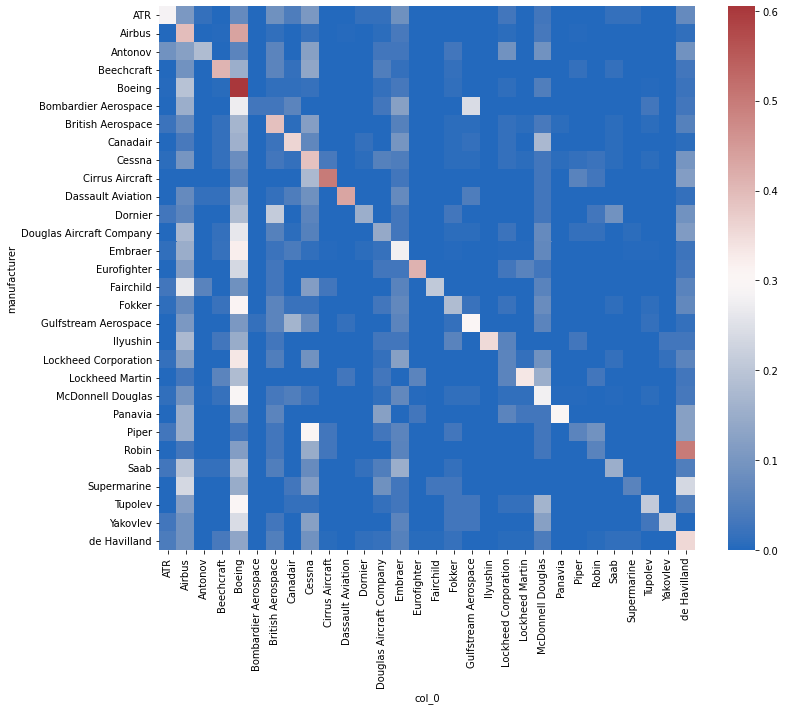

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(test_df['manufacturer'],
                        classify_images(X_test, model, test_df['manufacturer'].astype('category').cat.categories),
                        normalize='index'),
            cmap='vlag',
            ax=ax);

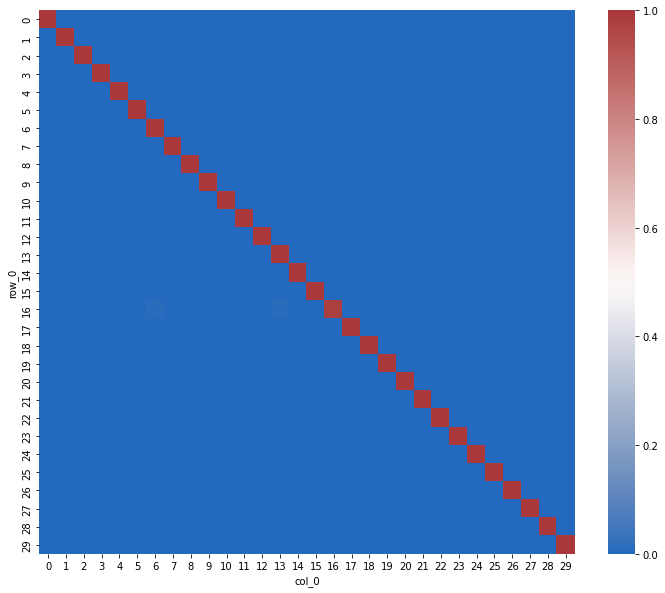

In [ ]:
# il a bien appris car on est dans le train
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(np.argmax(y_train, axis=1), classify_images(X_train, model), normalize='index'),
            cmap='vlag',
            ax=ax);

Enregistrer le model

In [ ]:
# il enregistre avec date
import datetime

def save_model(model, basename):
  """Save tf/Keras model.

  Model file is named model + timestamp.

  Parameters
  ----------
  model (tf/Keras model): model to be saved
  basename: location to save model file
  """
  model.save('{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
  return

In [ ]:
save_model(model, 'model/planes')

In [ ]:
# voir ou il est enregistré + poids du modèle
!ls -lh model

total 297M
-rw-r--r-- 1 root root 149M Apr  3 17:49 planes_2022-04-03_17-49-38.h5
-rw-r--r-- 1 root root 149M Apr  3 18:06 planes_2022-04-03_18-06-17.h5


In [ ]:
reloaded_model = load_model('/content/model/planes_2022-04-03_18-06-17.h5')